# NLY Time Series Analysis

In [152]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import itertools

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace import sarimax

from dateutil.relativedelta import relativedelta


from aakey import key
aakey = key

### Accessing data through API Key

In [153]:
data = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=nly&outputsize=full&apikey={key}')
data = data.json()

In [154]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'nly',
 '3. Last Refreshed': '2020-02-14',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

### Creating DataFrame and formating index as datetime

In [155]:
df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient = 'index')

In [156]:
df.index = pd.to_datetime(df.index)

In [157]:
df.columns = ['open', 'high', 'low', 'close', 'volume']
for i in df.columns:
    df[[f'{i}']] = df[[f'{i}']].apply(pd.to_numeric)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2020-02-14 to 2000-02-14
Data columns (total 5 columns):
open      5033 non-null float64
high      5033 non-null float64
low       5033 non-null float64
close     5033 non-null float64
volume    5033 non-null int64
dtypes: float64(4), int64(1)
memory usage: 235.9 KB


In [159]:
df.tail()

,open,high,low,close,volume
2000-02-18,8.125,8.125,7.938,8.000,38100
2000-02-17,7.813,8.250,7.813,8.063,16900
2000-02-16,7.750,8.063,7.750,7.938,20900
2000-02-15,7.250,7.750,7.250,7.750,52400
2000-02-14,7.625,7.625,7.188,7.250,55100


In [160]:
#df['daily_change'] = df['close'] - df['open']

### Removing unecessary columns

In [161]:
df.drop(['high','low', 'open', 'volume'], axis=1, inplace = True)

In [168]:
#df[["close"]] = df[["close"]].apply(pd.to_numeric)

### Preserving original DF values

In [169]:
df_full = df


### Removing outliers; if there are any

In [165]:
stan_dev_cutoff = df.std().sum() * 2.5
low_cutoff = df.mean().sum() - stan_dev_cutoff 
high_cutoff = df.mean().sum() + stan_dev_cutoff

print(low_cutoff, high_cutoff)
print(df.loc[df['close'] > high_cutoff])
print(df.loc[df['close'] < low_cutoff])
#df.drop(index =['2017-06-26', '2017-06-23'])

5.338922086265605 22.625331996786088
Empty DataFrame
Columns: [close]
Index: []
Empty DataFrame
Columns: [close]
Index: []


In [166]:
### Looking at the plot

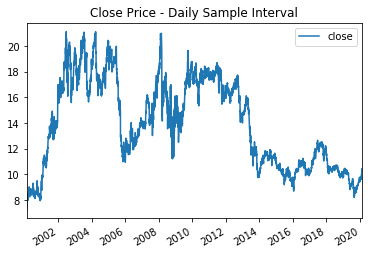

In [167]:
df.plot(title= 'Close Price - Daily Sample Interval');

In [130]:
dfm = df.resample('m').mean()
dfm_full = df_full.resample('m').mean()

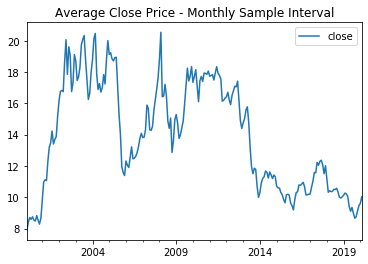

In [131]:
dfm.plot(title='Average Close Price - Monthly Sample Interval');

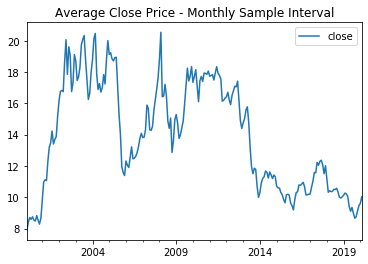

In [132]:
dfm_full.plot(title='Average Close Price - Monthly Sample Interval');

### Dickey Fuller - for stationarity
#### Need to difference to decrease the Dickey-Fuller coefficient below the 5% critical value

In [133]:
dfmd = dfm.diff().dropna()

dickyf = adfuller(dfmd['close'])
dickyf

(-7.9886343776392,
 2.5091435825549285e-12,
 3,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 533.2224342796833)

### Below is a plot of the diffrenced monthly average closing price. It is now stationary and we can now look at the ACF and PACF to visually approximate the AR and MA terms

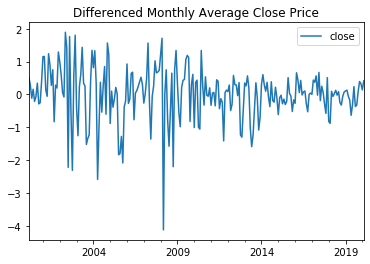

In [134]:
dfmd.plot(title = 'Differenced Monthly Average Close Price')

<Figure size 2160x720 with 0 Axes>

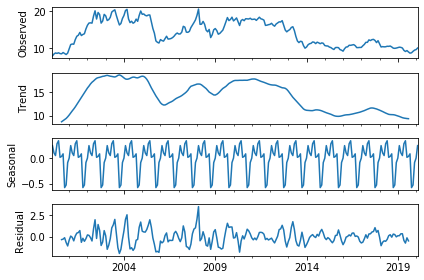

In [135]:
decomposition = seasonal_decompose(dfm, freq=12)
fig = plt.figure(figsize = (30,10))
fig = decomposition.plot();

### Auto-correlation function (ACF)

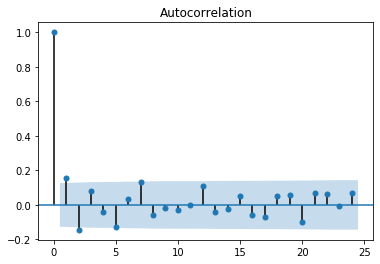

In [73]:
plot_acf(dfmd['close']);

### Partial auto-correlation function (PACF)

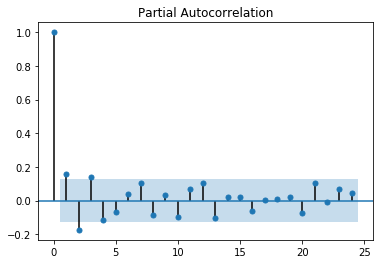

In [83]:
plot_pacf(dfmd['close']);

### Defining the range of p, d and q parameters to perform makeshift gridsearch optimization

~ Note - Since the time series was only stationary after 1 order of diffrencing, the lowest the 'd' term can be is 1.

In [94]:
p = q = range(0, 3)
d = range(1,3)
s = 12

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p,d,q))]

In [95]:
ans = []
best_terms = (0,0)
best_aic = 99999 ### arbitrary number to replace
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sarimax.SARIMAX(dfm['close'],
                                  order=comb,
                                  seasonal_order=combs,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            if output.aic < best_aic:
                best_aic = output.aic
                best_terms = (comb, combs)
        except:
            continue
        print(f'ARIMA {comb} x {combs} : AIC Calculated = {output.aic}')


ARIMA (0, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 684.2851203374178
ARIMA (0, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 538.6891176468154
ARIMA (0, 1, 0) x (0, 1, 2, 12) : AIC Calculated = 506.25439841034876
ARIMA (0, 1, 0) x (0, 2, 0, 12) : AIC Calculated = 890.5249764625601
ARIMA (0, 1, 0) x (0, 2, 1, 12) : AIC Calculated = 653.5923947561304
ARIMA (0, 1, 0) x (0, 2, 2, 12) : AIC Calculated = 514.6810415245947
ARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 601.2511787606438
ARIMA (0, 1, 0) x (1, 1, 1, 12) : AIC Calculated = 546.7990457191693
ARIMA (0, 1, 0) x (1, 1, 2, 12) : AIC Calculated = 490.39304629235755
ARIMA (0, 1, 0) x (1, 2, 0, 12) : AIC Calculated = 735.8967223882443
ARIMA (0, 1, 0) x (1, 2, 2, 12) : AIC Calculated = 526.6729883870014
ARIMA (0, 1, 0) x (2, 1, 0, 12) : AIC Calculated = 521.4304374468946
ARIMA (0, 1, 0) x (2, 1, 1, 12) : AIC Calculated = 520.69667994612
ARIMA (0, 1, 0) x (2, 1, 2, 12) : AIC Calculated = 497.73116567801657
ARIMA (0, 1, 0) x (2, 2, 0, 12) :

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12) : AIC Calculated = 508.193183363558
ARIMA (0, 2, 1) x (2, 1, 0, 12) : AIC Calculated = 526.9651229531949
ARIMA (0, 2, 1) x (2, 1, 1, 12) : AIC Calculated = 528.6193656094363
ARIMA (0, 2, 1) x (2, 1, 2, 12) : AIC Calculated = 493.88837048586686
ARIMA (0, 2, 1) x (2, 2, 0, 12) : AIC Calculated = 609.5965244829263
ARIMA (0, 2, 1) x (2, 2, 1, 12) : AIC Calculated = 544.0515453009752
ARIMA (0, 2, 1) x (2, 2, 2, 12) : AIC Calculated = 533.3311574868762
ARIMA (0, 2, 2) x (0, 1, 0, 12) : AIC Calculated = 671.0471139897933
ARIMA (0, 2, 2) x (0, 1, 1, 12) : AIC Calculated = 531.5544408303622
ARIMA (0, 2, 2) x (0, 1, 2, 12) : AIC Calculated = 499.5366062663563
ARIMA (0, 2, 2) x (0, 2, 0, 12) : AIC Calculated = 873.7147723767976
ARIMA (0, 2, 2) x (0, 2, 1, 12) : AIC Calculated = 641.3585949087092
ARIMA (0, 2, 2) x (0, 2, 2, 12) : AIC Calculated = 496.0578058317999
ARIMA (0, 2, 2) x (1, 1, 0, 12) : AIC Calculated = 598.2351459637588
ARIMA (0, 2, 2) x (1, 1, 1, 12) : 

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12) : AIC Calculated = 478.89485834507315
ARIMA (2, 1, 2) x (1, 2, 0, 12) : AIC Calculated = 716.2932036975676
ARIMA (2, 1, 2) x (1, 2, 1, 12) : AIC Calculated = 601.4333539587053


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12) : AIC Calculated = 505.8417500513905
ARIMA (2, 1, 2) x (2, 1, 0, 12) : AIC Calculated = 507.53207713252436
ARIMA (2, 1, 2) x (2, 1, 1, 12) : AIC Calculated = 504.21686567877515


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12) : AIC Calculated = 488.7661377022205
ARIMA (2, 1, 2) x (2, 2, 0, 12) : AIC Calculated = 578.3490126991903
ARIMA (2, 1, 2) x (2, 2, 1, 12) : AIC Calculated = 515.3184600688198


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12) : AIC Calculated = 504.8971626288828
ARIMA (2, 2, 0) x (0, 1, 0, 12) : AIC Calculated = 716.70097374483
ARIMA (2, 2, 0) x (0, 1, 1, 12) : AIC Calculated = 578.9171994813211
ARIMA (2, 2, 0) x (0, 1, 2, 12) : AIC Calculated = 545.5593796716785
ARIMA (2, 2, 0) x (0, 2, 0, 12) : AIC Calculated = 918.4860977029003
ARIMA (2, 2, 0) x (0, 2, 1, 12) : AIC Calculated = 685.1396753267101
ARIMA (2, 2, 0) x (0, 2, 2, 12) : AIC Calculated = 539.9171571120376
ARIMA (2, 2, 0) x (1, 1, 0, 12) : AIC Calculated = 628.8227269169329
ARIMA (2, 2, 0) x (1, 1, 1, 12) : AIC Calculated = 578.1409022118577
ARIMA (2, 2, 0) x (1, 1, 2, 12) : AIC Calculated = 528.9761036477346
ARIMA (2, 2, 0) x (1, 2, 0, 12) : AIC Calculated = 761.3799421507352
ARIMA (2, 2, 0) x (1, 2, 1, 12) : AIC Calculated = 640.240633856759
ARIMA (2, 2, 0) x (1, 2, 2, 12) : AIC Calculated = 552.3840926309688
ARIMA (2, 2, 0) x (2, 1, 0, 12) : AIC Calculated = 552.4339434188664
ARIMA (2, 2, 0) x (2, 1, 1, 12) : AIC

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12) : AIC Calculated = 536.5446033816374
ARIMA (2, 2, 1) x (1, 1, 2, 12) : AIC Calculated = 480.1373895654042
ARIMA (2, 2, 1) x (1, 2, 0, 12) : AIC Calculated = 723.0710447554189
ARIMA (2, 2, 1) x (1, 2, 1, 12) : AIC Calculated = 607.983698456113
ARIMA (2, 2, 1) x (1, 2, 2, 12) : AIC Calculated = 514.2984952985366
ARIMA (2, 2, 1) x (2, 1, 0, 12) : AIC Calculated = 512.7649769291367
ARIMA (2, 2, 1) x (2, 1, 1, 12) : AIC Calculated = 514.7373242921168
ARIMA (2, 2, 1) x (2, 1, 2, 12) : AIC Calculated = 496.02700283638524
ARIMA (2, 2, 1) x (2, 2, 0, 12) : AIC Calculated = 584.3288354361297
ARIMA (2, 2, 1) x (2, 2, 1, 12) : AIC Calculated = 524.0912836432673
ARIMA (2, 2, 1) x (2, 2, 2, 12) : AIC Calculated = 522.080610683942
ARIMA (2, 2, 2) x (0, 1, 0, 12) : AIC Calculated = 669.7674980431399
ARIMA (2, 2, 2) x (0, 1, 1, 12) : AIC Calculated = 531.3310117106963
ARIMA (2, 2, 2) x (0, 1, 2, 12) : AIC Calculated = 500.9884294059958
ARIMA (2, 2, 2) x (0, 2, 0, 12) : A

In [101]:
s12_values = (best_aic, best_terms)
s12_values

(472.7303339712853, ((0, 1, 2), (1, 1, 2, 12)))

### Evaluating/testing the optimized autoregressive, integrated, and moving average terms

In [104]:
model = sarimax.SARIMAX(dfm['close'], 
                        order=(0,1,2), 
                        seasonal_order = (1,1,2,12), 
                        enforce_stationarity=False,
                        enforce_invertibility=False)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  241
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -230.365
Date:                            Mon, 17 Feb 2020   AIC                            472.730
Time:                                    13:33:22   BIC                            492.550
Sample:                                02-29-2000   HQIC                           480.750
                                     - 02-29-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2552      0.059      4.293      0.000       0.139       0.372
ma.L2         -0.0792      0.071     -1.110      0.267      -0.219       0.061
ar.S.L12      -0.8041      0.054    -14.878      0.000      -0.910      -0.698
ma.S.L12      -0.1117    291.450     -0.000      1.000    -571.342     571.119
ma.S.L24      -1.1118    323.988     -0.003      0.997    -636.117     633.893
sigma2         0.3991    116.328      0.003      0.997    -227.600     228.398
===================================================================================
Ljung-Box (Q):                       43.24   Jarque-Bera (JB):               196.27
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

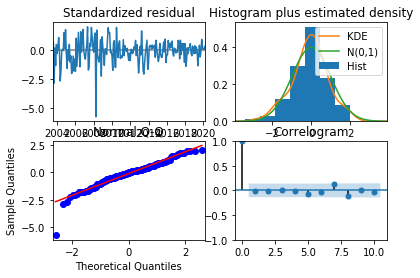

In [105]:
res.plot_diagnostics();

In [76]:
#pred_d = res.get_prediction(start= pd.to_datetime('2015-01-31'), dynamic=True, full_results=True)
#pred_d_conf = pred_d.conf_int()

In [136]:
dfm_full

,close
2000-02-29,7.915000
2000-03-31,8.429478
2000-04-30,8.707368
2000-05-31,8.593955
2000-06-30,8.753000
...,...
2019-10-31,8.752174
2019-11-30,9.146500
2019-12-31,9.474762
2020-01-31,9.614762


In [137]:
start = datetime.datetime.strptime("2020-03-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= dfm_full.columns)
dfm_full = pd.concat([dfm_full, future])

In [145]:
dfm_full.iloc[240]


close    10.031
Name: 2020-02-29 00:00:00, dtype: float64

In [150]:
res.predict(start=241, end= 300, dynamic= True)

2020-03-31    10.124687
2020-04-30    10.129878
2020-05-31     9.899494
2020-06-30     9.718622
2020-07-31     9.389769
2020-08-31     9.450581
2020-09-30     9.542425
2020-10-31     9.185699
2020-11-30     9.063133
2020-12-31     9.370533
2021-01-31     9.310957
2021-02-28     9.599791
2021-03-31     9.472072
2021-04-30     9.372965
2021-05-31     9.684180
2021-06-30     9.832674
2021-07-31     9.693088
2021-08-31     9.688906
2021-09-30     9.613314
2021-10-31     9.028158
2021-11-30     9.063194
2021-12-31     9.331971
2022-01-31     9.389796
2022-02-28     9.575465
2022-03-31     9.576569
2022-04-30     9.577411
2022-05-31     9.453149
2022-06-30     9.336814
2022-07-31     9.045047
2022-08-31     9.093124
2022-09-30     9.152160
2022-10-31     8.750674
2022-11-30     8.658990
2022-12-31     8.958822
2023-01-31     8.922250
2023-02-28     9.190869
2023-03-31     9.088392
2023-04-30     9.008870
2023-05-31     9.234756
2023-06-30     9.331359
2023-07-31     9.161954
2023-08-31     9

[]

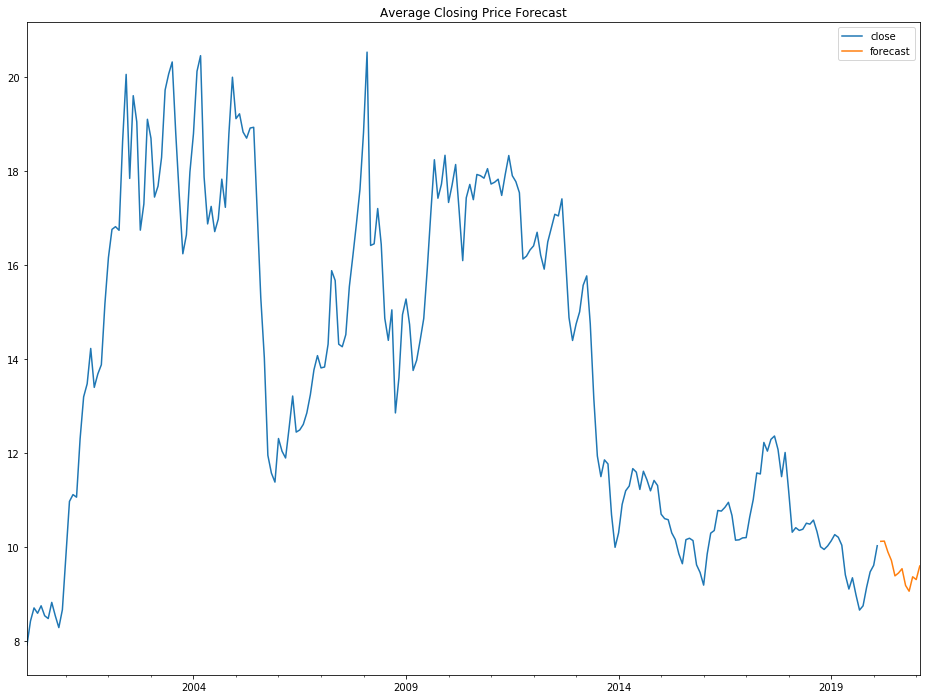

In [151]:
dfm_full['forecast'] = res.predict(start=241, end= 300, dynamic= True) 

dfm_full[['close', 'forecast']].plot(figsize=(16, 12), title='Average Closing Price Forecast'); 

plt.plot(x_label='year')